# Lightning Integration: Logging/Tensorboard + Deep Koopman Operators Example 

The following notebook is equivalent to /ODEs/Part_8_nonauto_DeepKoopman.ipynb, but now showcasing the use of **PyTorch-Lightning** to simplify the user workflow. 

We also show how to easily use **Tensorboard**



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
!pip install lightning 

## Imports

(The user might need to install PyTorch Lightning). If so, please run 

```
pip install lightning
```

In [1]:
import torch
import torch.nn as nn
import numpy as np
import lightning.pytorch as pl 

from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.slim import slim
from neuromancer.trainer import Trainer, LitTrainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

torch.manual_seed(0)

## Generate trajectories from ODE system 

In this example we don't assume any prior knowledge on the system dynamics. We will only have access to limited measurements of the system states $x$ of an unknown [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).

Select the system_name from the available list of [nonautonomous ODE systems](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/psl/nonautonomous.py):
- TwoTank
- CSTR
- SwingEquation
- IverSimple

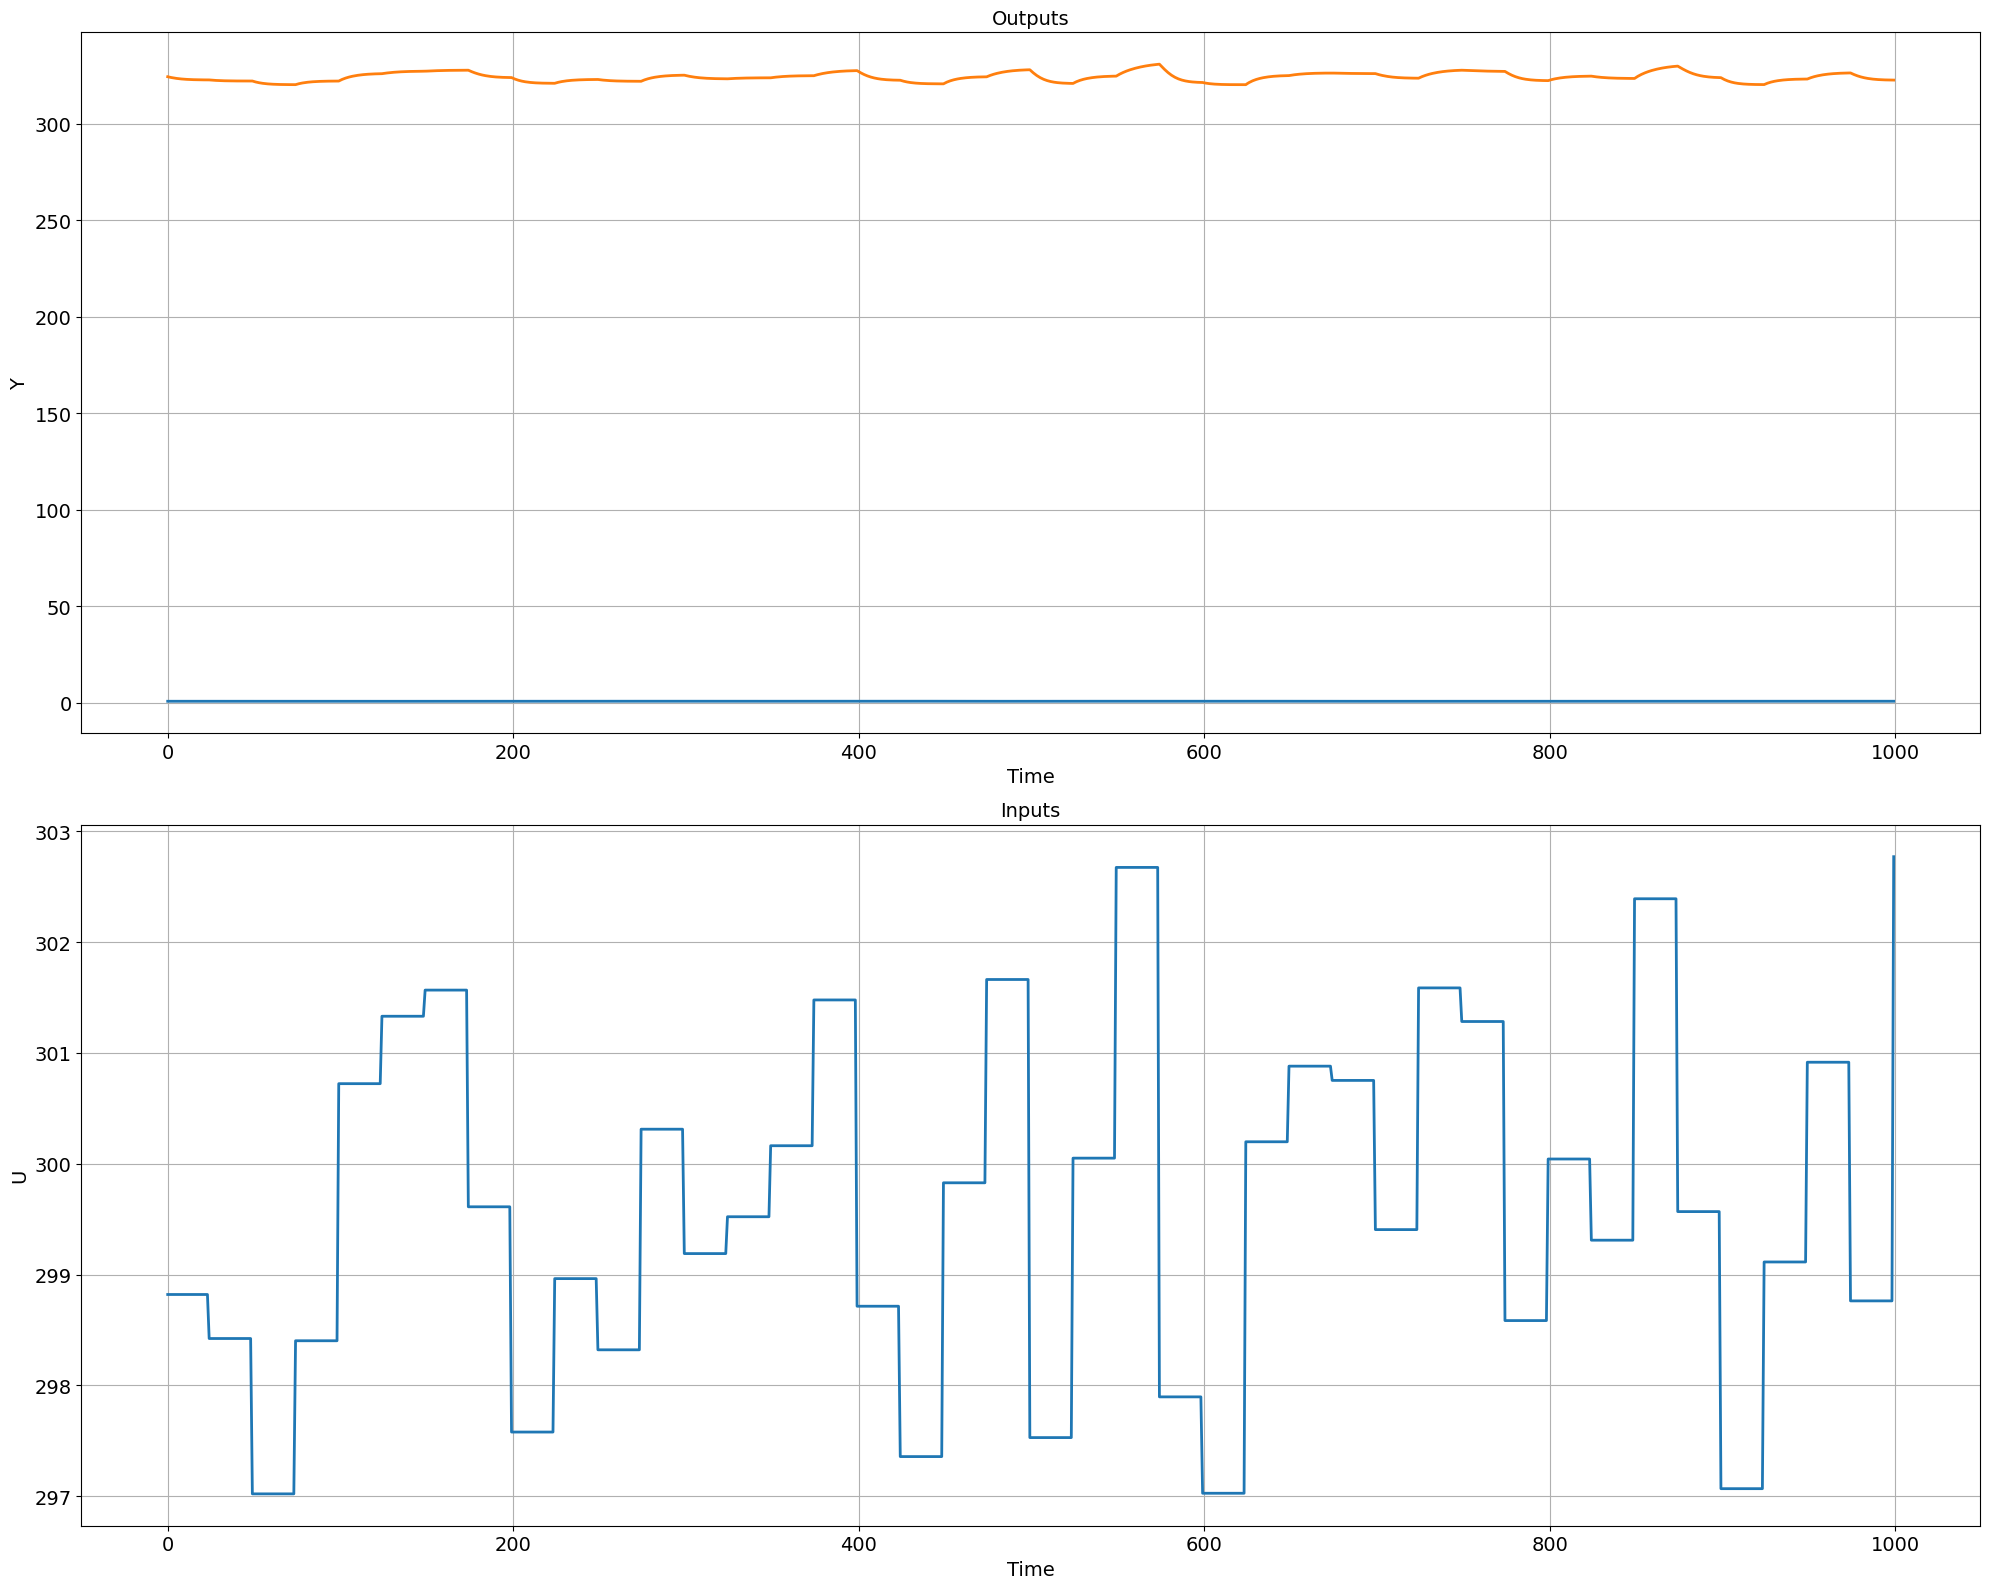

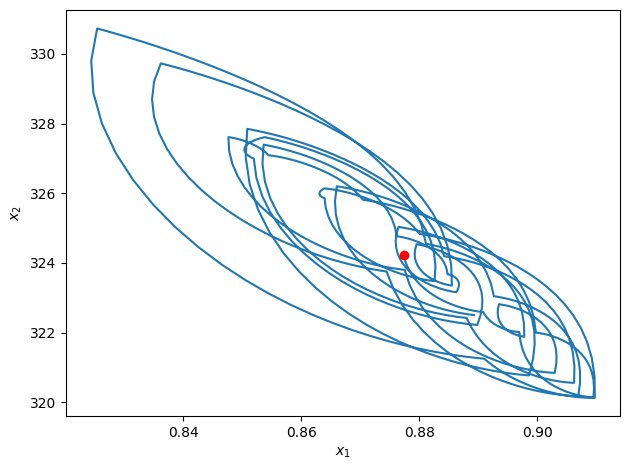

In [2]:
# %%  ground truth system
system = psl.systems['CSTR']
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
ny = modelSystem.ny
nu = modelSystem.nu
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'], U=raw['U'])
plot.pltPhase(X=raw['Y'])


## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics in the form of input-state tuples: 
$$D = \big[(u^i_0, \hat{x}^i_0), ..., (u^i_N, \hat{x}^i_{N}) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.
Variables $x_k$ represent system states, and $u_k$ are exogenous inputs at time $k$.

The **data_setup_function()** is defined here based off the base version of this notebook

In [3]:
def normalize(x, mean, std):
    return (x - mean) / std

def data_setup_function(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    mean_x = modelSystem.stats['Y']['mean']
    std_x = modelSystem.stats['Y']['std']
    mean_u = modelSystem.stats['U']['mean']
    std_u = modelSystem.stats['U']['std']
    

    trainX = normalize(train_sim['Y'][:length], mean_x, std_x)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = normalize(train_sim['U'][:length], mean_u, std_u)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'Y': trainX, 'Y0': trainX[:, 0:1, :],
                              'U': trainU}, name='train')


    devX = normalize(dev_sim['Y'][:length], mean_x, std_x)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = normalize(dev_sim['U'][:length], mean_u, std_u)
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'Y': devX, 'Y0': devX[:, 0:1, :],
                            'U': devU}, name='dev')


    testX = normalize(test_sim['Y'][:length], mean_x, std_x)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = normalize(test_sim['U'][:length], mean_u, std_u)
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'Y': testX, 'Y0': testX[:, 0:1, :],
                 'U': testU}
    

    return train_data, dev_data, test_data, bs

In [4]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 20   # number of prediction horizon steps in the loss function
bs = 100      # minibatching batch size


## Deep Koopman model in Neuromancer

Here we construct a discrete-time encoder-decoder Koopman model with control:   

<img src="../figs/Koopman_model.png" width="500">  


Encoder: $${x}_{k} = f_y(y_k) +f_u(u_k)$$ 
Koopman: $${x}_{k+1} = K(x_k)$$ 
Decoder: $$\hat{y}_{k+1} = f_y^{-1}(x_{k+1})$$  

In [5]:
# model parameters
nx_koopman = 50
n_hidden = 60
n_layers = 2

**Encoder and Decoder networks** 

In [6]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(ny, nx_koopman, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ELU,
                 hsizes=n_layers*[n_hidden])
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

In [7]:
# instantiate input encoder net f_u
f_u = blocks.MLP(nu, nx_koopman, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ELU,
                 hsizes=n_layers*[n_hidden])
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

In [8]:
# instantiate state decoder neural net f_y_inv
f_y_inv = blocks.MLP(nx_koopman, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ELU,
                hsizes=n_layers*[n_hidden])
# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

**Standard Koopman Operator** without stability guarantees is parametrized by linear layer of the latent size. 

**Stable Koopman Operator:**  For provably stable Koopman operator we can choose a range of linear algebra factorization that allow to constrain the eigenvalues of the resulting linear operator. 
In this example we use the following [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) factorization of the operator given as:
$$K = U \Sigma V$$ 
$$\Sigma =  \text{diag}(\lambda_{\text{max}} - (\lambda_{\text{max}} - \lambda_{\text{min}}) \cdot \sigma(\Lambda)) $$
where $\sigma$ is logistic sigmoid activation function, $\cdot$ is a dot product, $\Lambda$ is a vector of eigenvalues of the linear operator, while $\lambda_{\text{max}}$ and $\lambda_{\text{min}}$ are constraints on maximum and minimum value of SVD factorized linear operator.

<img src="../figs/SVD_layer.png" width="300">  

In order for the SVD factorization to hold the left and right matrices $U$ and $V$, respectively, needs to be [orthogonal](https://en.wikipedia.org/wiki/Orthogonal_matrix).
This can be achieved either via [Householder reflectors](https://arxiv.org/abs/1803.09327), or via penalties in the loss function given as:  
$$\ell_{U} = || I - UU^T||_2 + || I - U^TU||_2  $$
$$\ell_{V} = || I - VV^T||_2 + || I - V^TV||_2  $$
$$\ell_{\text{stable}} = \ell_{U} + \ell_{V} $$

For more details on the SVD and other linear algebra factorizations of trainable linear layers see the references [[7]](https://ieeexplore.ieee.org/document/9482930) and [[8]](https://ieeexplore.ieee.org/abstract/document/9809789), with Pytorch implementations in the [slim submodule](https://github.com/pnnl/neuromancer/tree/master/src/neuromancer/slim) of the Neuromancer library. 

In [9]:
# instantiate Koopman operator matrix
stable = True     # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(nx_koopman, nx_koopman,
                          sigma_min=0.01, sigma_max=1.0, bias=False)
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.*(K_reg_error == 0.0)
    K_reg_loss.name = 'SVD_loss'
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)

Below is the base class for Koopman control. Note that if we want to use any hardcoded tensors, one would need to have this class inherit from **pl.LightningModule** and use **type_as()**. Please refer to Part_1_stabilize_linear_system_lightning.ipynb notebook for more information 

In [10]:
class Koopman_control(nn.Module):
    """
    Baseline class for Koopman control model
    Implements discrete-time dynamical system:
        x_k+1 = K x_k + u_k
    with variables:
        x_k - latent states
        u_k - latent control inputs
    """

    def __init__(self, K):
        super().__init__()
        self.K = K

    def forward(self, x, u):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nx])
        :return: (torch.Tensor, shape=[batchsize, nx])
        """
        x = self.K(x) + u
        return x

In [11]:
# symbolic Koopman model with control inputs
Koopman = Node(Koopman_control(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [12]:
# dynamics_model.show()

In [12]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

## Define Koopman system identification loss function terms

Here we define loss function terms to fit the encoded-decoder Koopman parameters $\theta$ from given time-series data.
The loss function terms follow the implementation as given in the reference [[2]](https://www.nature.com/articles/s41467-018-07210-0). 

**Output trajectory prediction loss:**  
$$\ell_y = \sum_{k=1}^{N} Q_y||y^i_{k+1} - \hat{y}^i_{k+1}||_2^2$$ 
**One step output prediction loss:**  
$$\ell_{y_1} = Q_{y_1}||y^i_2 - \hat{y}^i_2||_2^2$$ 

where $\hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y^i_1))) $, 
and $N$ is defining length of the rollout (prediction) horizon.  

**Latent trajectory prediction loss:**  
$$\ell_{\text{lin}} = \sum_{k=1}^{N}  Q_x||\phi_{\theta_1}(y_{k+1}^i) - K^k\phi_{\theta_1}(y_1^i)||_2^2$$ 


In [13]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"


## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big( \ell_{y} + \ell_{y_1}  +\ell_{\text{lin}} + \ell_{\text{recon}} + \ell_{\text{stable}} \Big) \\
&\text{subject to}    && \hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y_1^i))) \\
\end{align}
$$  

In [14]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss]

if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [16]:
# plot computational graph
# problem.show()

# Tensorboard Visualization

We can invoke tensorboard directly using the following commands, as Lightning automatically will log training history to *lightning_logs*. The latest "version" should correspond to the most current training run. Please launch training in the 2nd cell below and then launch Tensorboard. This notebook was developed in VS Code and assumes the user 

In [16]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Launching TensorBoard...

In [ ]:
lit_trainer = LitTrainer(epochs=300,accelerator='cpu', devices='auto')
lit_trainer.fit(problem, data_setup_function , sys=modelSystem, nsim=nsim, nsteps=nsteps,ts=ts, bs=bs)


# Wandb Logging

We can also use a wandb logger to visualize using wandb library. To do that we run: 

For more information please see: https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.loggers.wandb.html

In [ ]:
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger()
lit_trainer = LitTrainer(epochs=300,accelerator='cpu', logger=wandb_logger)
lit_trainer.fit(problem, data_setup_function , sys=modelSystem, nsim=nsim, nsteps=nsteps,ts=ts, bs=bs)


## After Training

In [ ]:
problem = problem.to('cpu')

## System Identification results

In [18]:
_, _, test_data, _ = data_setup_function( sys=modelSystem, nsim=nsim, nsteps=nsteps,ts=ts, bs=bs)

In [19]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [20]:
# Test set results
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, nx).T
true_traj = test_data['Y'][:, 1:, :].detach().numpy().reshape(-1, nx).T
input_traj = test_data['U'].detach().numpy().reshape(-1, nu).T

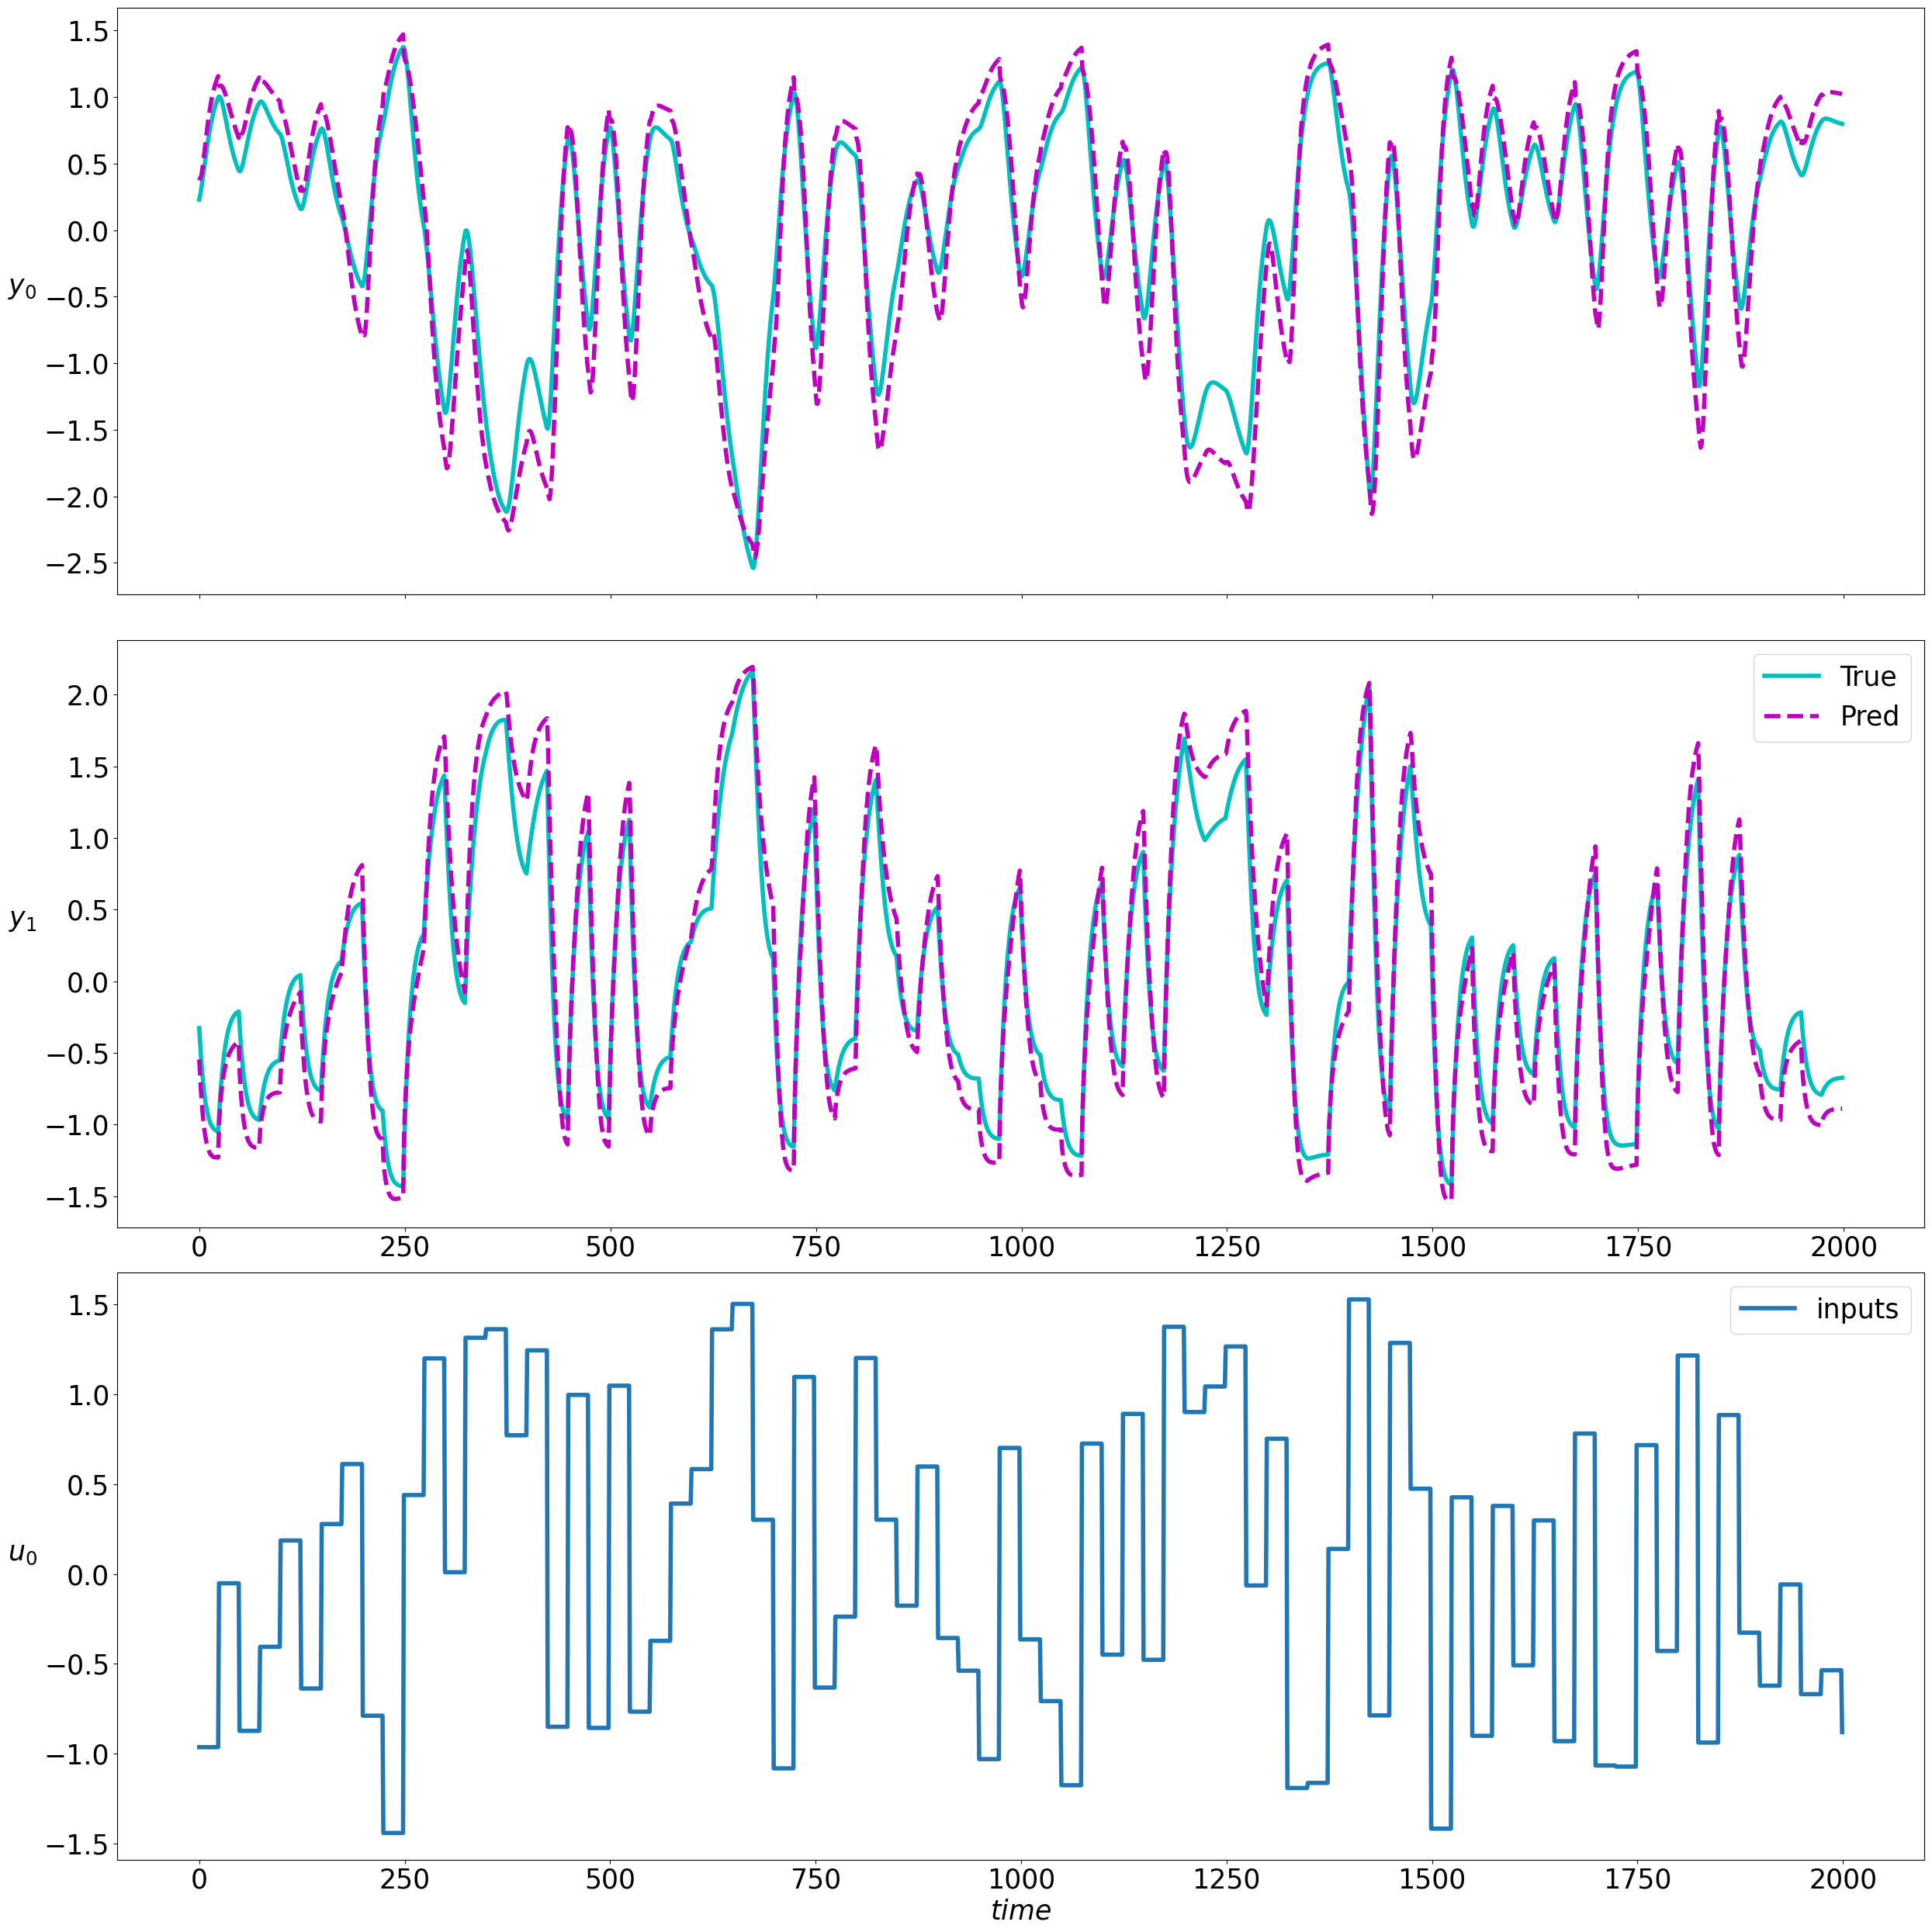

In [21]:
# plot trajectories
figsize = 25
fig, ax = plt.subplots(nx + nu, figsize=(figsize, figsize))

x_labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, x_labels)):
    axe = ax[row]
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)

u_labels = [f'$u_{k}$' for k in range(len(input_traj))]
for row, (u, label) in enumerate(zip(input_traj, u_labels)):
    axe = ax[row+nx]
    axe.plot(u, linewidth=4.0, label='inputs')
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

ax[-1].set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

In [22]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eReal = eig.real.detach().numpy()
eImag = eig.imag.detach().numpy()
# unit circle
t = np.linspace(0.0, 2 * np.pi, 1000)
x_circ = np.cos(t)
y_circ = np.sin(t)

Text(0.5, 0.98, 'Koopman operator eigenvalues')

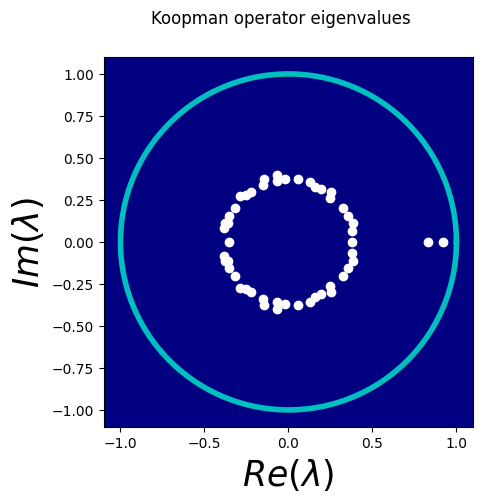

In [23]:
# plot Koopman eigenvalues
fig1, ax1 = plt.subplots()
ax1.plot(x_circ, y_circ, 'c', linewidth=4)
ax1.plot(eReal, eImag, 'wo')
ax1.set_aspect('equal', 'box')
ax1.set_facecolor("navy")
ax1.set_xlabel("$Re(\lambda)$", fontsize=figsize)
ax1.set_ylabel("$Im(\lambda)$", fontsize=figsize)
fig1.suptitle('Koopman operator eigenvalues')


In [24]:
# compute Koopman state eigenvectors
y_min = 1.1*test_data['Y'].min()
y_max = 1.1*test_data['Y'].max()
y1 = torch.linspace(y_min, y_max, 1000)
y2 = torch.linspace(y_min, y_max, 1000)
yy1, yy2 = torch.meshgrid(y1, y1)
plot_yy1 = yy1.detach().numpy()
plot_yy2 = yy2.detach().numpy()
# eigenvectors
features = torch.stack([yy1, yy2]).transpose(0, 2)
latent = f_y(features)
phi = torch.matmul(latent, abs(eig_vec))
# select first 6 eigenvectors
phi_1 = phi.detach().numpy()[:,:,0]
phi_2 = phi.detach().numpy()[:,:,1]
phi_3 = phi.detach().numpy()[:,:,2]
phi_4 = phi.detach().numpy()[:,:,3]
phi_5 = phi.detach().numpy()[:,:,4]
phi_6 = phi.detach().numpy()[:,:,6]


/home/birm560/miniconda3/envs/neuromancer3/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 0.98, 'first six eigenfunctions')

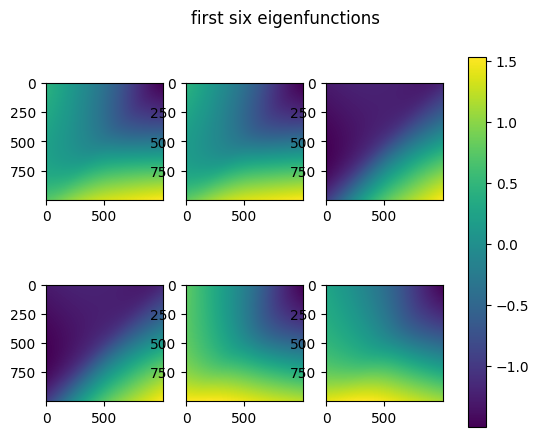

In [25]:
# plot eigenvectors
fig2, axs = plt.subplots(2, 3)
im1 = axs[0,0].imshow(phi_1)
im2 = axs[0,1].imshow(phi_2)
im3 = axs[0,2].imshow(phi_3)
im4 = axs[1,0].imshow(phi_4)
im5 = axs[1,1].imshow(phi_5)
im6 = axs[1,2].imshow(phi_6)
fig2.colorbar(im1, ax=axs)
fig2.suptitle('first six eigenfunctions')